In [1]:
__version__ = '2021-06-27'
__authors__ = ['Robert Nikutta <robert.nikutta@gmail.com>', 'Enrique Lopez-Rodriguez', 'Kohei Ichikawa']

# Hypercat - Simulating single-dish observations
This notebook shows how to simulate observations with single-dish instruments, including extremely large telescopes (30m-class).
It demonstrates how to use a telescope pupil image to produce a PSF and how to simulate synthetic observations, including PSF convolution, noise addition, and 

From telescope pupils to point spread functions (PSFs)

HYPERCAT can model telescope PSFs either from a Airy+2DGaussian approximation, or directly from telescope pupil images. For both approached the wavelength of the light is a free parameter.
HYPERCAT can also use a PSF provided by the user as an image. In this case the wavelength is "baked into" the PSF image.

## Disclaimer and Attribution
HYPERCAT / CLUMPY models and the accompanyin software were published in two papers. If you decide to make use of either the models, the software, the example notebooks, or the included pupil images of telescopes included with HYPERCAT, please cite these two papers:

* **Nikutta, Lopez-Rodriguez, Ichikawa, Levenson, Packham, Hönig, Alonso-Herrero, "Hypercubes of AGN Tori (Hypercat) -- I. Models and Image Morphology", ApJ (2021, accepted)**

* **Nikutta, Lopez-Rodriguez, Ichikawa, Levenson, Packham, Hönig, Alonso-Herrero, "Hypercubes of AGN Tori (Hypercat) -- II. Resolving the
torus with Extremely Large Telescopes", ApJ (2021, under review)**


## Table of contents
* [Imports & setup](#import)
* [Pupil images](#pupil)
* [Simulating observations with a single-dish telescope, including PSF convolution](#simobs)
* [Simulating noisy observations](#noisyobservations)
  * [Recovering image flux and detail by deconvolution of simulated observations](#deconvolution)
* [Observe with multiple telescopes](#observemultitelescopes)
* [Prescribe a specific detector pixel scale](#detectorpixelscale)
* [Notes on flux preservation](#fluxpreservation)
* [Observe at multiple wavelengths](#multiwave)
* [Further information](#info)

<a class="anchor" id="import"></a>
## Imports and setup

In [2]:
# std lib
import pprint as P  # for pretty-printing some data sctructures
pprint = P.PrettyPrinter(indent=2,width=200).pprint
import warnings
warnings.filterwarnings("ignore", message="dataset.value has been deprecated")
from itertools import chain

# 3rd party
import numpy as np
from astropy import units as u 
from astropy.io import fits
import pylab as plt

# own
import hypercat as hc
from hypercat import ioops
from hypercat import plotting
from hypercat import psf
from hypercat import obsmodes
from hypercat import imageops
print("HYPERCAT version:",hc.__version__)

HYPERCAT version: 0.1.5


<a class="anchor" id="pupil"></a>
## Pupil images
Here we show how to use the telescope pupil images that come with HYPERCAT. To load a pupil image we have to provide a short dictionary with just the 'telescope' keyword set:

In [3]:
pupil, header = psf.getPupil({'telescope':'TMT'})

We can use the `multiplot` helper function to visualize it.

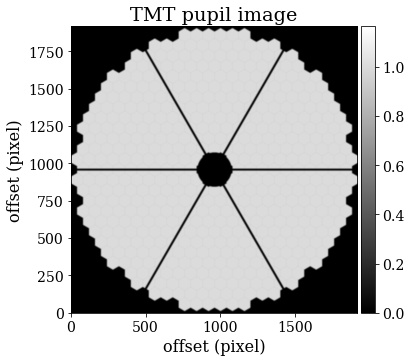

In [4]:
plotting.multiplot(pupil,panelsize=6,cmaps='gray',titles=('TMT pupil image'));

The `header` is an astropy Header object, and contains some useful information, e.g. about the pixelscale of the pupil image. The info can be used for instance to produce image axes in units of meters:

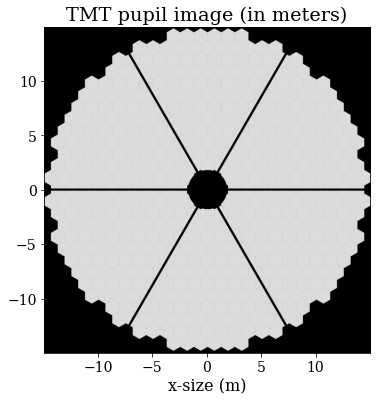

In [5]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
pupil, header = psf.getPupil({'telescope':'TMT'})
pixscale = header['PIXSCALE']
npix = header['NAXIS1']
radius = npix*pixscale/2
ax.imshow(pupil.T,origin='lower',extent=(-radius,radius,-radius,radius),cmap='gray')
ax.set_xlabel('x-size (m)')
ax.set_xlabel('x-size (m)')
ax.set_title('TMT pupil image (in meters)');

We can plot the pupils of the other telescopes included with HYPERCAT:

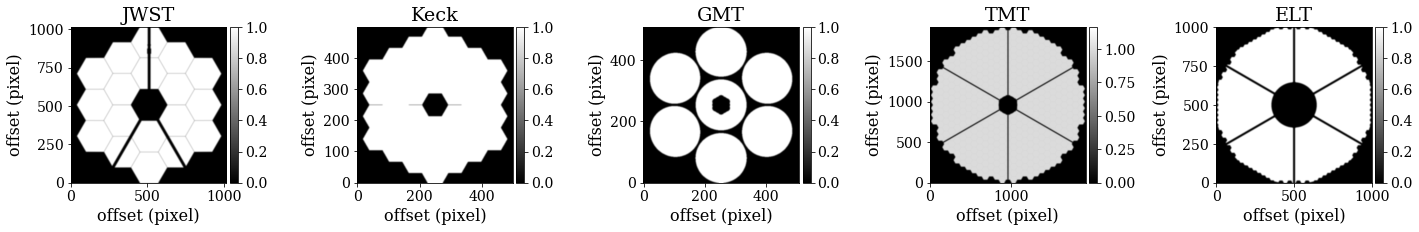

In [6]:
telescopenames = ('JWST','Keck','GMT','TMT','ELT')
pupils = [psf.getPupil({'telescope':'%s' % tel})[0].T for tel in telescopenames]
plotting.multiplot(pupils,panelsize=4,cmaps='gray',titles=telescopenames,sharex=False,sharey=False);

<a class="anchor" id="simobs"></a>
## Simulating observations with a single-dish telescope, including PSF convolution

Let's load the model cube again and generate an AGN source, using NGC1068 values as an example:

In [7]:
fname = 'hypercat_20181031_all.hdf5' # use your local location to the HDF5 model file
cube = hc.ModelCube(fname,hypercube='imgdata')
ngc1068 = hc.Source(cube,luminosity='1.6e45 erg/s',distance='14.4 Mpc',objectname='ngc1068',pa='42 deg')  # assuming Tsub=1500K, this sets pixelscale

Opening HDF5 file: hypercat_20181031_all.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'imgdata' [shape: (5,10,16,12,5,7,25,121,241)] to RAM (912.52 GB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, ...
   Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, ...
   N*    [  1.000 -  12.000]  ( 12)     1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000, ...
   q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  tv*    [ 10.000 - 160.000]  (  7)    10.000, 20.000, 40.000, 60.000, 80.000,120.000,160.000
wave*    [  1.2

Let's also create a model image of the AGN, at 4.5 micron:

In [8]:
wave = 4.5
vec = (40,85,20,6,0.08,80,wave)  # thes are the values for: sig [degrees], i [degrees], Y, N, q, tv, wave [micron]
img_model = ngc1068(vec,total_flux_density='2.0 Jy')

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.


We now want to simulate observing this model image with TMT. We will make the TMT as an instance of the `Imaging` class first; all we need are the name of the telescope (to get the correct pupil image), the wavelength of the observations (which we have already set above as `wave`), and a detector pixelscale. If we don't know the detector pixel scale yet, we can simply select 'Nyquist', which will select a pixel scale half the size of the telescope PSF.

In [9]:
psfdict = {'psfmode':'pupil', 'telescope':'TMT', 'wavelength':'%g micron' % wave, 'pixelscale_detector':'Nyquist'}
tmt = obsmodes.Imaging(psfdict)

Pixel scale in PSF image is: 30.972 mas per pixel


The object `tmt` now has a useful method called `observe()` which we of course can use to observe our model image as if it were the image of our AGN in the sky:

In [10]:
img_observed, psf_orig, psf_resampled = tmt.observe(img_model)

self.PSF: Computed pixelscale from pupil = 
The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20386 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (15.486 mas) was slightly adjusted due to discretization (now 15.3213 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (15.486 mas) was slightly adjusted due to discretization (now 15.27 mas). This is to preserve sizes on the sky.
Coordinates for source 'ngc1068' resolved. WCS created.


The warnings about pixel scale adjustment are due to minor corrections to the pixelscale applied by HYPERCAT such that the number of pixels along each image axis is always odd (to ensure our central source is always a single pixel).

Let's plot the model image, the observed image and the PSF resampled like the model image:

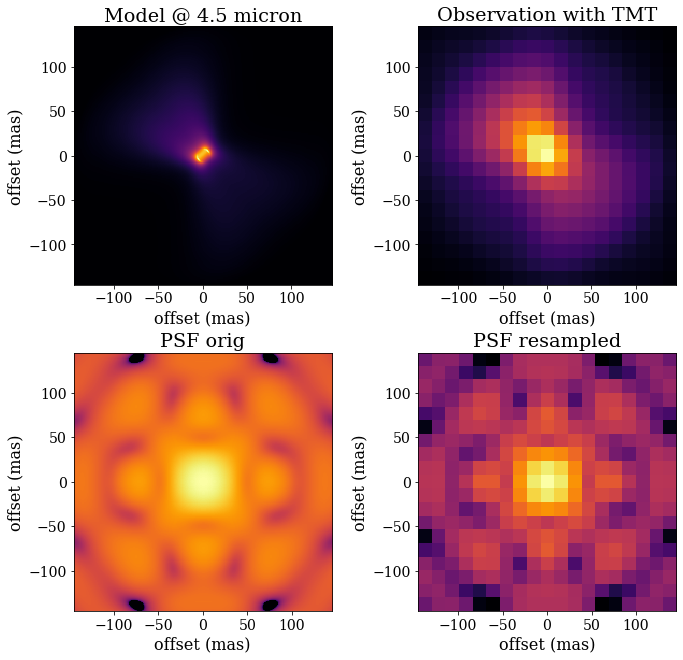

In [11]:
plotting.multiplot((img_model,img_observed,psf_orig,psf_resampled),geometry=(2,2),panelsize=5,sharex=False,sharey=False,
                    interpolation='none',cmaps='inferno',colorbars=None,
                    titles=('Model @ %g micron' % wave,'Observation with %s' % psfdict['telescope'],'PSF orig','PSF resampled'));

<a class="anchor" id="noisyobservations"></a>
## Simulating noisy observations
In real life observations will be noisy, e.g. from source brightness fluctuations, read-out noise of the detector, etc.

We can approximate such noise sources (in the IR and optical regime, where we are far away from Poissonian photon noise) by prescribing a certain signal to noise ratio (SNR) to the input model image. HYPERCAT by default measures the SNR at the brightest/peak pixel level.

In [12]:
SNR = 40
img_observed_noisy, psf_orig_noisy, psf_resampled_noisy = tmt.observe(img_model,snr=SNR)

self.PSF: Computed pixelscale from pupil = 
The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20386 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (15.486 mas) was slightly adjusted due to discretization (now 15.3213 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (15.486 mas) was slightly adjusted due to discretization (now 15.27 mas). This is to preserve sizes on the sky.
Coordinates for source 'ngc1068' resolved. WCS created.


And we'll plot again:

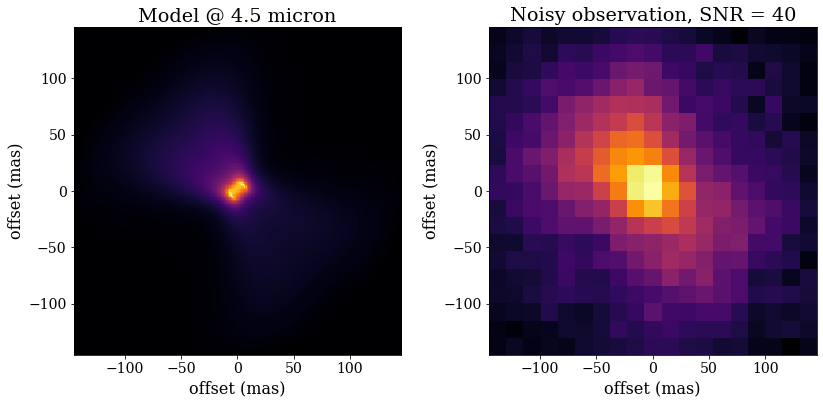

In [13]:
plotting.multiplot((img_model,img_observed_noisy),geometry=(2,2),panelsize=6,sharex=False,sharey=False,
                    interpolation='none',cmaps='inferno',colorbars=None,
                    titles=('Model @ %g micron' % wave,'Noisy observation, SNR = %g' % SNR));

<a class="anchor" id="image deconvolution"></a>
### Recovering image flux and detail by deconvolution of simulated observations (ideal case, and noisy)
Using Richardson-Lucy deconvolution, a cleaner image can be recovered if both an observed image and the PSF image used for the observation are available. This works also in the noisy case.

In [14]:
niter = 5 # number iof iterations for Richardson-Lucy deconvolution
img_observed_deconv = psf_resampled.deconvolve(img_observed,niter=niter)
img_observed_noisy_deconv = psf_resampled_noisy.deconvolve(img_observed_noisy,niter=niter)

And let's plot again:

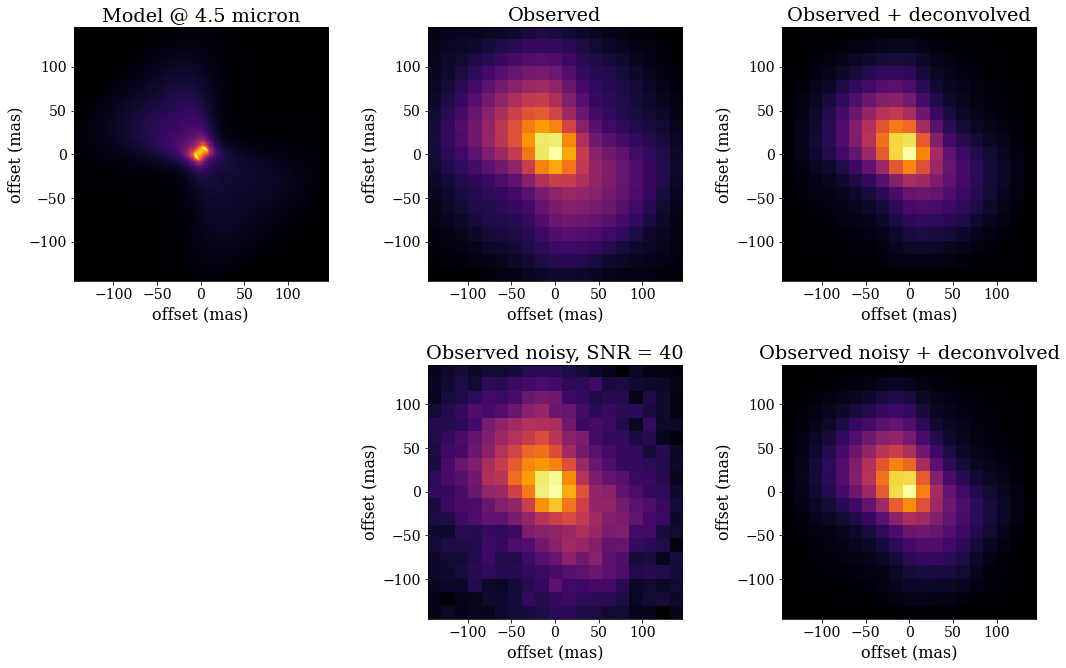

In [15]:
plotting.multiplot((img_model,img_observed,img_observed_deconv,None,img_observed_noisy,img_observed_noisy_deconv),
                    geometry=(2,3),direction='y',panelsize=5,sharex=False,sharey=False,
                    interpolation='none',cmaps='inferno',colorbars=None,
                    titles=('Model @ %g micron' % wave,'Observed','Observed + deconvolved',None,'Observed noisy, SNR = %g' % SNR,'Observed noisy + deconvolved'));

<a class="anchor" id="observemultitelescopes"></a>
## Observe with multiple telescopes
We can compare results of simulating observations with several telescopes at the same wavelength by feeding the model image to different instances of the `Imaging` object (the "telescopes").

Let's create the telescopes first:

In [16]:
telescopes = []
for tel in telescopenames:
    print("%s: " % tel,end='')
    psfdict = {'psfmode':'pupil', 'telescope':tel, 'wavelength':'%g micron' % wave, 'pixelscale_detector':'Nyquist'}
    telescopes.append(obsmodes.Imaging(psfdict))

JWST: Pixel scale in PSF image is: 141.668 mas per pixel
Keck: Pixel scale in PSF image is: 105.656 mas per pixel
GMT: Pixel scale in PSF image is: 34.9515 mas per pixel
TMT: Pixel scale in PSF image is: 30.972 mas per pixel
ELT: Pixel scale in PSF image is: 23.1759 mas per pixel


Now for each telescope we generate the synthetic noisy observation (with a given SNR), and the deconvolved image, and add both to a list of all observations.

In [17]:
SNR = 40
niter = 5
observations = []
for jtel,tel in enumerate(telescopenames):
    print(tel)
    obs_noisy, psf_orig_noisy, psf_resampled = telescopes[jtel].observe(img_model,snr=SNR)
    observations.append(obs_noisy)
    obs_noisy_deconv = psf_resampled_noisy.deconvolve(obs_noisy,niter=niter)
    observations.append(obs_noisy_deconv)

JWST
self.PSF: Computed pixelscale from pupil = 
The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.21084 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (70.8341 mas) was slightly adjusted due to discretization (now 58.2208 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (70.8341 mas) was slightly adjusted due to discretization (now 58.3624 mas). This is to preserve sizes on the sky.
Coordinates for source 'ngc1068' resolved. WCS created.
Keck
self.PSF: Computed pixelscale from pupil = 
The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20521 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (52.8282 mas) was slightly adjusted due to discretization (now 58.2208 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (52.8282 mas) was slightly adjust

Finally let's plot the model image and the noisy and the deconvolved observations:

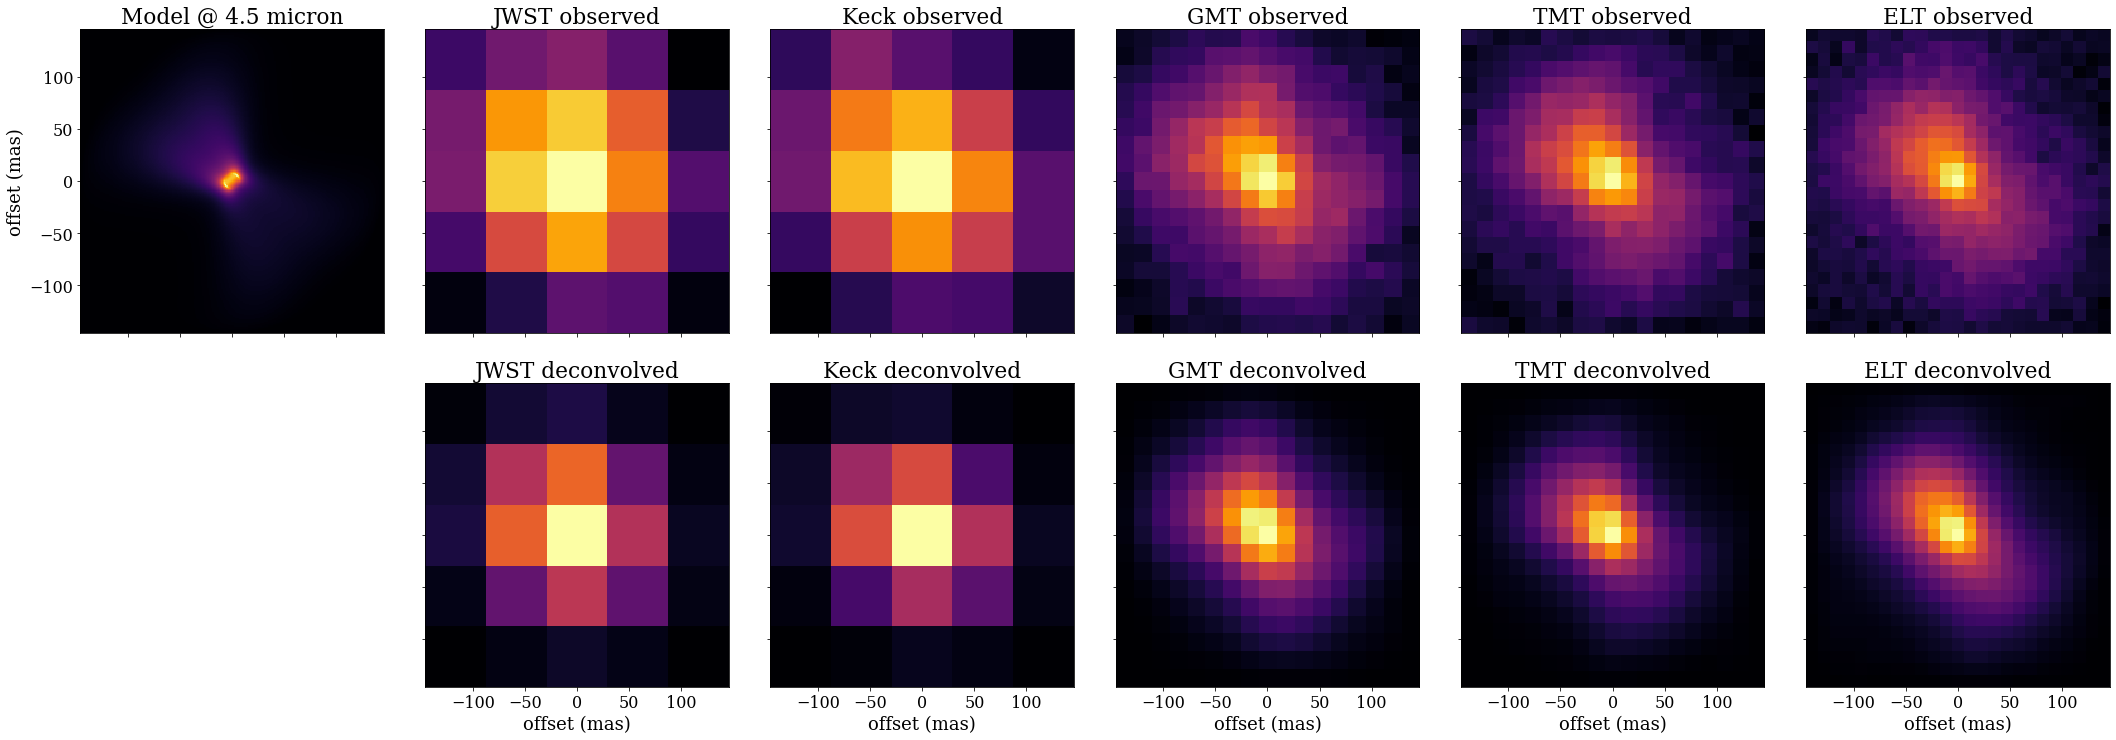

In [18]:
images = [img_model,None] + observations
titles = ['Model @ %g micron' % wave,None] + list(chain.from_iterable([["%s observed" % tel, "%s deconvolved" % tel] for tel in telescopenames]))

plotting.multiplot(images,geometry=(2,6),direction='x',panelsize=5,
                   interpolation='none',cmaps='inferno',colorbars=None,titles=titles,fontsize=18);
plt.subplots_adjust(hspace=0.15)

Note how all three upcoming extremely large telescopes will potentially be able to resolve the IR emission in nearby AGN sources.

<a class="anchor" id="detectorpixelscale"></a>
## Prescribe a specific detector pixel scale

In the examples above we used Nyquist sampling for image resolution. If you want to simulate an image with a telescope and a particular detector pixel scale, you can provide that pixel scale information in the `psfdict` dictionary:

In [19]:
psfdict = {'psfmode':'pupil', 'telescope':'TMT', 'wavelength':'%g micron' % wave, 'pixelscale_detector':'25 mas'}
tmt = obsmodes.Imaging(psfdict)

Pixel scale in PSF image is: 30.972 mas per pixel


As before, we now generate the observed image (noisy) and then deconvolve it, and plot both together with the original model image:

self.PSF: Computed pixelscale from pupil = 
The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20386 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (25 mas) was slightly adjusted due to discretization (now 26.464 mas). This is to preserve sizes on the sky.
The requested resampling to pixel scale (25 mas) was slightly adjusted due to discretization (now 26.3754 mas). This is to preserve sizes on the sky.
Coordinates for source 'ngc1068' resolved. WCS created.


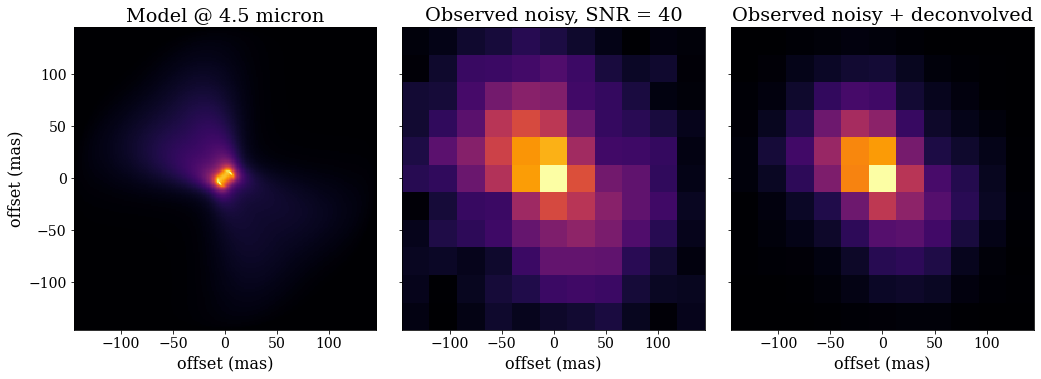

In [20]:
SNR = 40
img_observed_noisy, psf_orig_noisy, psf_resampled_noisy = tmt.observe(img_model,snr=SNR)

niter = 5
img_observed_noisy_deconv = psf_resampled_noisy.deconvolve(img_observed_noisy,niter=niter)

plotting.multiplot((img_model,img_observed_noisy,img_observed_noisy_deconv),
                    panelsize=5,interpolation='none',cmaps='inferno',colorbars=None,
                    titles=('Model @ %g micron' % wave,'Observed noisy, SNR = %g' % SNR,'Observed noisy + deconvolved'));

<a class="anchor" id="fluxpreservation"></a>
## Notes on flux preservation
Please be aware that PSF convolution of a model image with a well-defined total flux density can "smear out" some of the flux outside of the FOV. Also, deconvolution techniques can, in some cases, lead to small changes in the total recovered flux density.

In [21]:
img_model.F  # .F is shorthand for the .getTotalFluxDensity() method

<Quantity 1.9999999 Jy>

In [22]:
img_observed_noisy.F

<Quantity 1.74796037 Jy>

In [23]:
img_observed_noisy_deconv.F

<Quantity 1.74796037 Jy>

<a class="anchor" id="multiwave"></a>
## Observe at multiple wavelengths
Of course one can observe a model image at any wavelength. Below we define the wavelengths, the corresponding flux densities, and the observe them all with three telescopes (GMT, TMT, ELT).

In [24]:
%%capture

waves = (4.78,8.99,11.88,18.72)
flux_densities = ('2.5 Jy','5.69 Jy','10.105 Jy','18.784 Jy') # flux densities for NGC1068 from Lopez-Rodriguez+2018 (ApJ, 859)

telescopenames = ('GMT','TMT','ELT')

SNR = 40
niter = 5

# generate model images
images_model = []
for jw,wave in enumerate(waves):
    vec = (43,75,18,4,0.08,70,wave)
    images_model.append(ngc1068(vec,total_flux_density=flux_densities[jw]))

# generate model observations
images_observed_noisy_deconv = []
for tel in telescopenames:
    print(tel)
    for jw,wave in enumerate(waves):
        print(wave)
        psfdict = {'psfmode':'pupil', 'telescope':tel, 'wavelength':'%g micron' % wave, 'pixelscale_detector':'Nyquist'}
        telescope = obsmodes.Imaging(psfdict)
        
        img_observed_noisy, psf_orig_noisy, psf_resampled_noisy = telescope.observe(images_model[jw],snr=SNR)
        img_observed_noisy_deconv = psf_resampled_noisy.deconvolve(img_observed_noisy,niter=niter)
        images_observed_noisy_deconv.append(img_observed_noisy_deconv)

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.
Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.
Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.
Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.
Pixel scale in PSF image is: 37.1263 mas per pix

We plot them models and images in a grid of wavelengths (rows) and telescopes (columns):

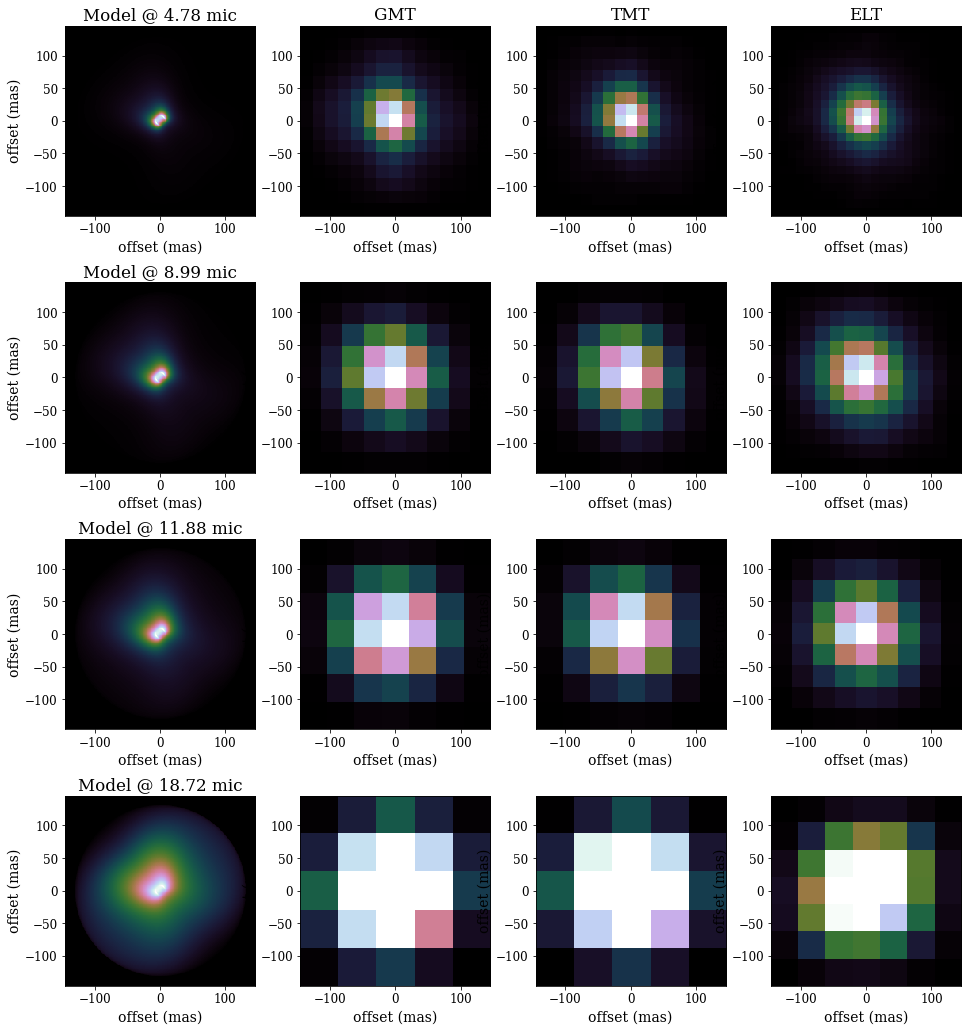

In [25]:
images = images_model + images_observed_noisy_deconv
titles = ["Model @ %g mic" % wave for wave in waves] + [telescopenames[0],None,None,None] + [telescopenames[1],None,None,None] + [telescopenames[2],None,None,None]

plotting.multiplot(images,geometry=(len(telescopenames)+1,len(waves)),direction='y',panelsize=3.5,
                   interpolation='none',cmaps='cubehelix',colorbars=None,fontsize=14,titles=titles,sharex=False,sharey=False);
plt.subplots_adjust(hspace=0.35,wspace=0.1)

<a class="anchor" id="info"></a>
## Further information
* For a demonstration of other capabilities of HYPERCAT, please check out the various other notebooks in: https://github.com/rnikutta/hypercat/tree/master/examples/